In [1]:
from netgen.occ import *
from ngsolve import *
from ngsolve.webgui import Draw
import os
import pyvista as pv

In [2]:
def BaseShape(l, w):
    wp1 = WorkPlane().RectangleC(l,w).Face()
    wp2 = WorkPlane().RectangleC(w,l).Face()
    cross = wp1 + wp2
    return cross


l = 0.3
w = 1
base = BaseShape(l, w)

In [3]:
offset = 3
figure = base
for i in range(3):
    for j in range(3):
        if (i+j) % 2 == 0:
            figure += BaseShape(i,j).Move((i*offset, j*offset, 0))
        else:
            if i+j == 1:
                figure += WorkPlane().Circle(1).Face().Move((i*offset, j*offset, 0))
            else:
                figure += base.Mirror(Axis((0, 0, 0), (1, 0, 0))
                      ).Move((i*offset, j*offset, 0))


geo = WorkPlane().Rectangle(5,5).Face() -  figure.Move((-2,-2,0))
Draw(geo)

geo.edges.Min(Y).name ='bottom'
geo.edges.Max(Y).name ='top'
geo.edges.Min(X).name ='left'
geo.edges.Max(X).name ='right'

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

In [4]:
plate = OCCGeometry(geo, dim=2)
mesh = Mesh(plate.GenerateMesh(maxh=0.5)).Curve(3)
Draw (mesh);


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

In [5]:
def solve_FEM():
    # H1-conforming finite element space
    fes = H1(mesh, order=1, dirichlet="bottom", autoupdate=True)
    # define trial- and test-functions
    u = fes.TrialFunction()
    v = fes.TestFunction()
    
    # the bilinear-form 
    a = BilinearForm(grad(u)*grad(v)*dx)
    
    funcf = 1*x*y
    # funcf = 50*sin(y)
    f = LinearForm(funcf*v*dx)
    
    a.Assemble()
    f.Assemble()
    # Draw(funcf,mesh)
    gfu = GridFunction(fes)
    gfu.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs()) * f.vec
    return gfu, fes

In [6]:
gfu, fes = solve_FEM()

# def export_to_png(mesh,gfu,filename, fieldname):
#     vtk = VTKOutput(mesh,coefs=[gfu],names=[fieldname],filename="./vtk_export",subdivision=2)
#     vtk.Do()
        
#     # Read the VTU file
#     mesh = pv.read("./vtk_export.vtu")
    
    
#     # Step 2: Check if the "sol" field exists
#     if fieldname in mesh.point_data:

#         plotter = pv.Plotter(window_size=[800, 800])
#         plotter.add_mesh(mesh, scalars=fieldname, cmap="seismic", show_scalar_bar=False)  
#         plotter.add_mesh(mesh, color="white", style="wireframe", show_scalar_bar=False)
#         plotter.view_xy()
#         plotter.add_scalar_bar(title=filename, vertical=True,  
#             position_x=0.90,  # X position (0.0 to 1.0, from left to right)
#             position_y=0.15,   # Y position (0.0 to 1.0, from bottom to top)
#             width=0.05,       # Width of the colorbar
#             height=0.70        # Height of the colorbar
#         )
#     else:
#         raise ValueError('didnt find field in vtk data')
    
#         plotter.show(screenshot=filename)
    

In [7]:
def export_to_png(mesh, gfu, fieldname, filename):
    vtk = VTKOutput(mesh,coefs=[gfu],names=[fieldname],filename="./vtk_export",subdivision=0)
    vtk.Do()
        
    # Read the VTU file
    meshpv = pv.read("./vtk_export.vtu")
    
    
    # Step 2: Check if the "sol" field exists
    if fieldname in meshpv.point_data:
    
        plotter = pv.Plotter(window_size=[300, 300])
        plotter.add_mesh(meshpv, scalars=fieldname, show_scalar_bar=False, cmap='seismic')  
        plotter.add_mesh(meshpv, color="white", style="wireframe", show_scalar_bar=False)
        plotter.view_xy()
        plotter.add_scalar_bar(title=fieldname, vertical=True,  
            position_x=0.90,  # X position (0.0 to 1.0, from left to right)
            position_y=0.15,   # Y position (0.0 to 1.0, from bottom to top)
            width=0.05,       # Width of the colorbar
            height=0.70,)
        plotter.show(screenshot=filename)

In [8]:
# export_to_png(mesh, gfu, fieldname='u', filename = 'blaagh')

In [9]:
import numpy as np
import torch

def export_vertex_coordinates(mesh):
    vertex_coordinates = []
    
    for v in mesh.vertices:
        vertex_coordinates.append(v.point)
    
    vertex_array = torch.tensor(np.array(vertex_coordinates))
    return vertex_array

In [10]:
vertex_array = export_vertex_coordinates(mesh).to(torch.float32)

mesh_x , mesh_y = vertex_array.T
print(vertex_array[:7])

tensor([[0.0000, 5.0000],
        [0.0000, 0.0000],
        [3.0000, 5.0000],
        [3.0000, 3.0000],
        [5.0000, 3.0000],
        [5.0000, 0.0000],
        [0.5000, 0.5000]])


In [11]:
solution_array =  torch.tensor([x for x in gfu.vec])
solution_array.shape, vertex_array.shape

(torch.Size([121]), torch.Size([121, 2]))

In [12]:
import torch
import numpy as np
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, figure
from matplotlib.markers import MarkerStyle
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [13]:
batch_size = 4
# Step 2: Create a TensorDataset
dataset = TensorDataset(vertex_array, solution_array.reshape(-1,1))

# Step 3: Create a DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataset[0]

(tensor([0., 5.]), tensor([63.9474]))

In [14]:
class FeedForward(nn.Module):

    def __init__(self, mesh_x, mesh_y):
        super(FeedForward, self).__init__()

        self.optimizer = None
        self.train_loss_history = []

        # weights for the total loss function
        self.w_data     = 0.01   #loss_data
        self.w_interior = 1      #loss_interior
        self.w_bc       = 5      #loss_bc

        self.hidden_size = 50

        # 2 input features
        self.b1 = nn.Linear(2, self.hidden_size)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.b3 = nn.Linear(self.hidden_size, 1)

        # initialize weights
        nn.init.xavier_uniform_(self.b1.weight)
        nn.init.xavier_uniform_(self.b2.weight)
        nn.init.xavier_uniform_(self.b3.weight)

        self.mesh_x  = mesh_x
        self.mesh_y  = mesh_y
 
    def forward(self, x, y):  

        xy = torch.stack((x, y), dim=1)

        h1 = torch.tanh(self.b1(xy))
        h2 = torch.tanh(self.b2(h1))
        u = self.b3(h2)

        return u

    
    def compute_derivative(self, u, x, n):
        # General formula to compute the n-th order derivative of u = f(x) with respect to x
        if n == 0:
            return u
        else:
            du_dx = torch.autograd.grad(u, x, torch.ones_like(u).to(device),
                                        create_graph=True, retain_graph=True,
                                        allow_unused=True)[0]

        return self.compute_derivative(du_dx, x, n - 1)

    
    def PDE_residual(self, x, y, use_meshgrid = False):
        if use_meshgrid:

            X,Y = torch.meshgrid(x,y)
            xy = torch.stack((X.flatten(), Y.flatten()), dim=1)

        x = torch.tensor(x, dtype=torch.float32).to(device)
        y = torch.tensor(y, dtype=torch.float32).to(device)
        x.requires_grad=True
        y.requires_grad=True

        u = self.forward(x, y)

        d2u_dx2 = self.compute_derivative(u, x, 2)
        d2u_dy2 = self.compute_derivative(u, y, 2)

        residual = d2u_dx2 + d2u_dy2 + x*y  
        return residual

    
    def loss_data(self):
        # xy, u = next(iter(dataloader))
        torch.manual_seed(42)
        idx = torch.randint(len(dataset), (10,))
        xy, u = dataset[idx]
        
        x, y  = xy.unbind(axis=1)

        x = torch.tensor(x, dtype=torch.float32).to(device)
        y = torch.tensor(y, dtype=torch.float32).to(device)
        u = torch.tensor(u, dtype=torch.float32).to(device)

        u_pred = self.forward(x, y)
        loss_data = torch.mean(torch.square(u - u_pred))
        return loss_data

    
    def loss_interior(self): #uniform sampling of x and y between [0,1] to pass to PDE_residual
        #x_samples = torch.FloatTensor(self.num_samples, 1).uniform_(0, 1).flatten().to(device).requires_grad_(True)
        #y_samples = torch.FloatTensor(self.num_samples, 1).uniform_(0, 1).flatten().to(device).requires_grad_(True)
        res = self.PDE_residual(self.mesh_x, self.mesh_y)
        loss_residual = torch.mean(torch.square(res)) #like rms error
        return loss_residual
        

    def loss_boundary_condition(self):

        self.x_bottom = torch.linspace(0, 5, 300).reshape(-1)
        self.y_bottom = torch.zeros(1, 300).reshape(-1)

        bc_pred_bottom = self.forward(self.x_bottom.to(device), self.y_bottom.to(device))
        loss_bc_bottom = torch.mean(torch.square(bc_pred_bottom))

        loss_bc = loss_bc_bottom 
        return loss_bc

    
    def compute_losses(self):  
        loss_interior = self.loss_interior()
        loss_data = self.loss_data()
        loss_bc = self.loss_boundary_condition()
        return loss_interior, loss_data, loss_bc


    def closure(self):
        self.optimizer.zero_grad()
        loss_interior, loss_data, loss_bc = self.compute_losses() 
        total_loss = self.w_data * loss_data + self.w_interior * loss_interior + self.w_bc * loss_bc   
        total_loss.backward(retain_graph=True)
        return total_loss

    
    def get_training_history(self):
        loss_hist = np.array(self.train_loss_history)
        total_loss, loss_bc, loss_interior, loss_data = np.split(loss_hist, 4, axis=1)
        return total_loss, loss_bc, loss_interior, loss_data

    
    def plot_losses(self):
            total_loss, loss_interior, loss_data, loss_bc = self.get_training_history()

            plt.figure(figsize=(8, 6))

            plt.subplot(2, 2, 1)
            plt.plot(total_loss, marker=MarkerStyle('o', fillstyle='none'), color='black', label='Total Loss')
            plt.yscale('log')
            plt.legend()

            plt.subplot(2, 2, 2)
            plt.plot(loss_bc, marker=MarkerStyle('o', fillstyle='none'), color='red', alpha = 0.8, label='Boundary Condition Loss')
            plt.yscale('log')
            plt.legend()

            plt.subplot(2, 2, 3)
            plt.plot(loss_interior, marker=MarkerStyle('o', fillstyle='none'), color='blue', alpha = 0.2, label='Interior Loss')
            plt.yscale('log')
            plt.legend()

            plt.subplot(2, 2, 4)
            plt.plot(loss_data, marker=MarkerStyle('o', fillstyle='none'), color='green', alpha = 0.1, label='Data Loss')
            plt.yscale('log')
            plt.legend()

            plt.tight_layout()
            plt.show()

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = FeedForward(mesh_x=mesh_x, mesh_y = mesh_y).to(device)
print(model)
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

cpu
FeedForward(
  (b1): Linear(in_features=2, out_features=50, bias=True)
  (b2): Linear(in_features=50, out_features=50, bias=True)
  (b3): Linear(in_features=50, out_features=1, bias=True)
)
Params: 2751


In [16]:
def train(self, epochs, optimizer='Adam', w_interior=1, w_bc=1, w_data=0.01, **kwargs):
        if optimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), **kwargs)

        elif optimizer == 'L-BFGS':
            self.optimizer = torch.optim.LBFGS(self.parameters(), **kwargs)

        # Training loop
        for epoch in range(epochs):
            self.optimizer.step(self.closure)
            
            # track progress and accumulate loss data for plotting
            if epoch % 1000 == 0:
                loss_interior, loss_data, loss_bc = self.compute_losses()
                total_loss = loss_interior + loss_bc 

                self.train_loss_history.append([total_loss.cpu().detach().numpy(),
                                                loss_interior.cpu().detach().numpy(),
                                                loss_data.cpu().detach().numpy(),
                                                loss_bc.cpu().detach().numpy(),
                                                
                                                ])

                print(f'Epoch ({optimizer}): {epoch}, Total Loss: {total_loss.detach().cpu().numpy()}')

In [17]:
def plot_model_error(model, mesh, gfu):
    u_pred = model.forward(model.mesh_x.to(device).float(), model.mesh_y.to(device).float())
    u_pred = u_pred.detach().cpu().numpy()
    u_plot = GridFunction(fes)
    u_plot.vec[:] = BaseVector(u_pred.flatten())
    #

    directory = './images'
    if not os.path.exists(directory): # Create the directory if it does not exist 
        os.makedirs(directory)
    
    #Draw((u_plot - gfu)*(u_plot - gfu), mesh, filename=directory + '/error.png')
    # Draw((u_plot - gfu)*(u_plot - gfu), mesh) #report the integral sum of error as a number keep history
    
    export_to_png(mesh,(u_plot - gfu)*(u_plot - gfu) , 'error' , 'error')
    

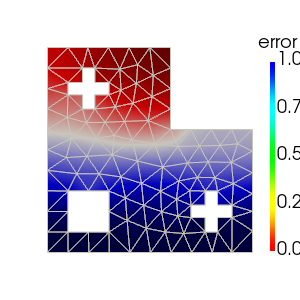

In [18]:
plot_model_error(model, mesh, gfu)

In [19]:
def refine_mesh(model, fe_space, mesh):
    res = model.PDE_residual(model.mesh_x, model.mesh_y).detach().numpy()
    residuals = GridFunction(fe_space)
    residuals.vec[:] = BaseVector(res.flatten())
    residuals = (residuals)*(residuals) #integrate not element-wise but over entire domain to get one number
    eta2 = Integrate(residuals, mesh, VOL, element_wise=True)
    maxerr = max(eta2)
    # Draw(residuals, mesh)
    export_to_png(mesh, residuals ,  'residuals' , 'residuals')
    
    # mark for refinement (vectorized alternative)
    mesh.ngmesh.Elements2D().NumPy()["refine"] = eta2.NumPy() > 0.25*maxerr
    mesh.Refine()
    
    mesh_x, mesh_y = export_vertex_coordinates(mesh).unbind(1)
    model.mesh_x = mesh_x
    model.mesh_y = mesh_y

In [20]:
def adapt_mesh_and_train(model, mesh):
    fe_solution, fe_space = solve_FEM()
    train(model, 3_000, lr=1e-3)
    # plot_model_error(model, mesh, fe_solution)
    refine_mesh(model, fe_space, mesh)



Epoch (Adam): 0, Total Loss: 35.85552978515625
Epoch (Adam): 1000, Total Loss: 0.11311526596546173
Epoch (Adam): 2000, Total Loss: 0.01284976489841938


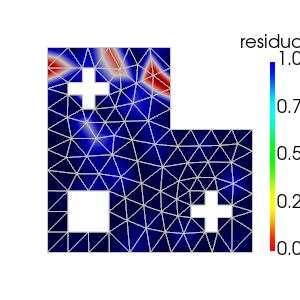

Epoch (Adam): 0, Total Loss: 1.745078444480896
Epoch (Adam): 1000, Total Loss: 0.006279353052377701
Epoch (Adam): 2000, Total Loss: 0.002367202891036868


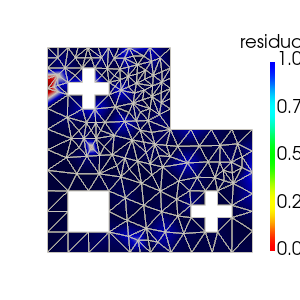

Epoch (Adam): 0, Total Loss: 0.41194045543670654
Epoch (Adam): 1000, Total Loss: 0.0017848701681941748
Epoch (Adam): 2000, Total Loss: 0.002140816766768694


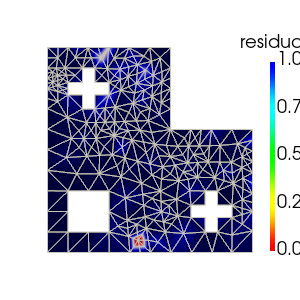

Epoch (Adam): 0, Total Loss: 0.29825708270072937
Epoch (Adam): 1000, Total Loss: 0.00120574701577425
Epoch (Adam): 2000, Total Loss: 0.003014765214174986


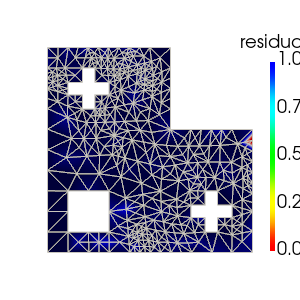

Epoch (Adam): 0, Total Loss: 0.4641803503036499
Epoch (Adam): 1000, Total Loss: 0.0007365127094089985
Epoch (Adam): 2000, Total Loss: 0.0019822046160697937


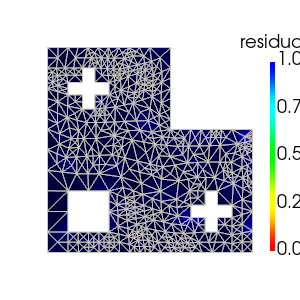

In [21]:
for iteration in range(5):
    adapt_mesh_and_train(model, mesh)

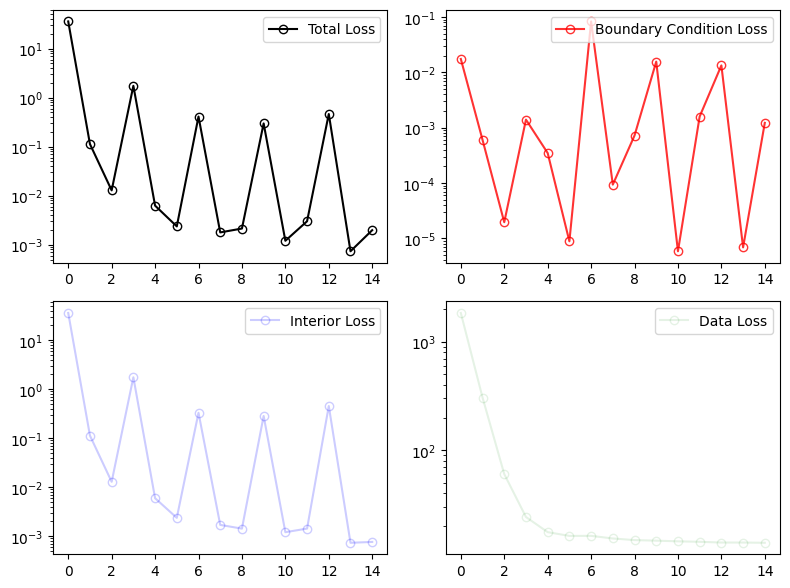

In [22]:
model.plot_losses()

In [23]:
# mesh.ngmesh.Export()